# Coursework 1: Chest X-ray (100 marks)

In this coursework, you will be working with the Kaggle [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data) dataset. You will analyze the dataset, and train deep learning models to classify whether an x-ray exhibits pneumonia.


The coursework is structured as follows:

1. Data Analysis: 5 marks
2. Data Preparation: 5 marks
3. Training a Baseline: 30 marks
4. Improving the Baseline: 50 marks
5. Evaluating on the Test Set: 10 marks

In each question will require you tocode up a solution, and to briefly explain and discuss your choices and results.

__IMPORTANT__
* Pretrained models are __NOT__ allowed. You will recieve __0__ marks for any use of pretrained models.
* The use of LLM/AI support including writing and coding aligns to the UCL guidelines. This includes the use of code prompts and Gemini in Google Collab

Here are some additional tips:
- We recommend using weights and biases to log your training runs. This will allow you to easily compare previous runs if needed.
- Ensure your results are reproducable - we may rerun your notebook to check for this. Points will be lost if results are not reproducable.
- We recommend factorizing your code in places where you will be repeatedly using the same functionaility. For example, if you are training multiple models, consider using a common training loop function.
- Your code and results and discussions should be concise, well-presented, and easy to read. Each question has a certain portion of marks going towards this.
- Ensure you correctly use the train, validation, and test set throughout. You should only ever use the test set once - for the final evaluation.
- Consider saving your models so you can reload previous models for the final evaluation
- Ensure it is clear to the reader what any plots / figures are presenting. I.e., label axes, include titles, ensure it is clear what experiment it is from (what model / design choices, etc.)
- Google Collab restricts the amount of GPU time available. Consider debugging code, using a subset of data, on CPU compute

In [1]:
!pip -q install kaggle
!pip -q install wandb

If you get the following error when running the import cell below this description:


```
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
```
You will need to create a kaggle account, and navigate to https://www.kaggle.com/me/account. Navigate to "API" and create a new token. This will automatically download a json file called "kaggle.json".

Run the following code, replacing the "INSERT JSON HERE TEXT" with the contents of the json that you downloaded.

```
!mkdir /root/.config/kaggle
!touch /root/.config/kaggle/kaggle.json

api_token = INSERT JSON HERE TEXT

import json

with open('/root/.config/kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /root/.config/kaggle/kaggle.json
```

INSERT JSON HERE TEXT should be something of the form:
```
{"username":"XXX","key":"XXX"}
```

In [2]:
import os
import random
import shutil
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
import matplotlib.pyplot as plt
import numpy as np

import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import models, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import wandb

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve, auc

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and Re-split the Raw Data

The original data is poorly split, so we will resplit it here. Do NOT edit this code.

In [4]:
# Hyperparameters
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1  # This is implicitly defined as 1 - (TRAIN_SPLIT + VAL_SPLIT)

In [5]:
# Set up the Kaggle API
api = KaggleApi()
api.authenticate()

# Specify the dataset
dataset = "paultimothymooney/chest-xray-pneumonia"

# Specify the download path
# Changed the download path to another directory to avoid uploading them to the cloud, which current directory does
download_path = "D:/datasets/ucl/chest_xray_dataset"

# Check if the dataset is already downloaded
if os.path.exists(os.path.join(download_path, "chest_xray")):
    print(f"Dataset already exists at {download_path}. Skipping download.")
else:
    # Create the download directory if it doesn't exist
    os.makedirs(download_path, exist_ok=True)

    # Download the dataset
    print(f"Downloading {dataset} to {download_path}")
    api.dataset_download_files(dataset, path=download_path, unzip=True)
    print("Download complete!")

Dataset already exists at D:/datasets/ucl/chest_xray_dataset. Skipping download.


In [25]:
# Re-split data
dataset_path = os.path.join(download_path, "chest_xray")
new_dataset_path = "D:/datasets/ucl/chest_xray_dataset_new_split"

if not os.path.exists(new_dataset_path):
    # Create new directory structure
    for split in ['train', 'val', 'test']:
        for cls in ['NORMAL', 'PNEUMONIA']:
            os.makedirs(os.path.join(new_dataset_path, split, cls), exist_ok=True)

    for cls in ['NORMAL', 'PNEUMONIA']:
        all_files = []
        for split in ['train', 'val', 'test']:
            source_folder = os.path.join(dataset_path, split, cls)
            files = os.listdir(source_folder)
            all_files.extend([(file, source_folder) for file in files])

        # Sort files to ensure consistent order before shuffling
        all_files.sort()

        # Create a new Random object with the seed
        rng = random.Random(42)

        # Use the shuffle method of the Random object
        rng.shuffle(all_files)

        total_files = len(all_files)
        train_end = int(total_files * TRAIN_SPLIT)
        val_end = int(total_files * (TRAIN_SPLIT + VAL_SPLIT))

        train_files = all_files[:train_end]
        val_files = all_files[train_end:val_end]
        test_files = all_files[val_end:]

        for split, file_list in [('train', train_files), ('val', val_files), ('test', test_files)]:
            for file, source_folder in file_list:
                source = os.path.join(source_folder, file)
                dest = os.path.join(new_dataset_path, split, cls, file)
                shutil.copy(source, dest)

    print(f"Data re-split complete. New dataset location: {new_dataset_path}")
else:
    print(f"Re-split dataset already exists at {new_dataset_path}")

Re-split dataset already exists at D:/datasets/ucl/chest_xray_dataset_new_split


# Question 1: Data Analysis (5 marks)

Perform some basic analysis of the statistics of the dataset.

Try to spot anything that may impact how you will design your deep learning classifier and training.

We'd expect to see:
* Analysis of labels (target variable);
* Analysis of input features;

If you do spot anything, briefly explain **how you think it may impact training**.


In [7]:
# Collect dataset statistics
splits = ['train', 'val', 'test']
classes = ['NORMAL', 'PNEUMONIA']

stats = {split: {cls: 0 for cls in ['NORMAL', 'PNEUMONIA']} for split in ['train', 'val', 'test']}
for split in splits:
    for cls in classes:
        path = os.path.join(new_dataset_path, split, cls)
        stats[split][cls] = len(os.listdir(path))

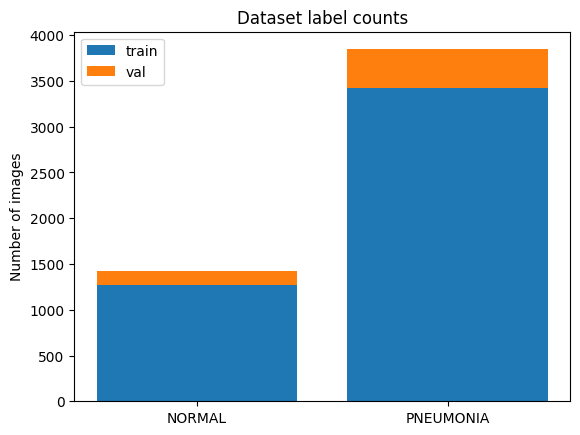

Normal images samples: 1266 training, 158 validation
Pneumonia images samples: 3418 training, 427 validation
Percentages in training samples: 27.03% normal, 72.97% pneumonia

Train size: 4684
Val size: 585
Test size: 587



In [9]:
########################################################################
#                              YOUR CODE HERE                          #
########################################################################

# Label distribution
plt.figure()
plt.bar(classes, [stats['train'][cls] for cls in classes], label='train')
plt.bar(classes, [stats['val'][cls] for cls in classes], bottom=[stats['train'][cls] for cls in classes], label='val')
plt.ylabel('Number of images')
plt.title('Dataset label counts')
plt.legend()
plt.show()

print(f"Normal images samples: {stats['train']['NORMAL']} training, {stats['val']['NORMAL']} validation")
print(f"Pneumonia images samples: {stats['train']['PNEUMONIA']} training, {stats['val']['PNEUMONIA']} validation")
print(f"Percentages in training samples: {stats['train']['NORMAL'] / (stats['train']['NORMAL'] + stats['train']['PNEUMONIA']) * 100:.2f}% normal, {stats['train']['PNEUMONIA'] / (stats['train']['NORMAL'] + stats['train']['PNEUMONIA']) * 100:.2f}% pneumonia")

print(f"""
Train size: {stats['train']['NORMAL'] + stats['train']['PNEUMONIA']}
Val size: {stats['val']['NORMAL'] + stats['val']['PNEUMONIA']}
Test size: {stats['test']['NORMAL'] + stats['test']['PNEUMONIA']}
""")

Normal image 0 shape: (1317, 1857)
Normal image 1 shape: (1837, 2031)
Normal image 2 shape: (1326, 1663)
Normal image 3 shape: (1443, 1852)
Normal image 4 shape: (1916, 2144)
Pneumonia image 0 shape: (760, 1152)
Pneumonia image 1 shape: (863, 1244)
Pneumonia image 2 shape: (940, 1242)
Pneumonia image 3 shape: (616, 1008)
Pneumonia image 4 shape: (480, 856)


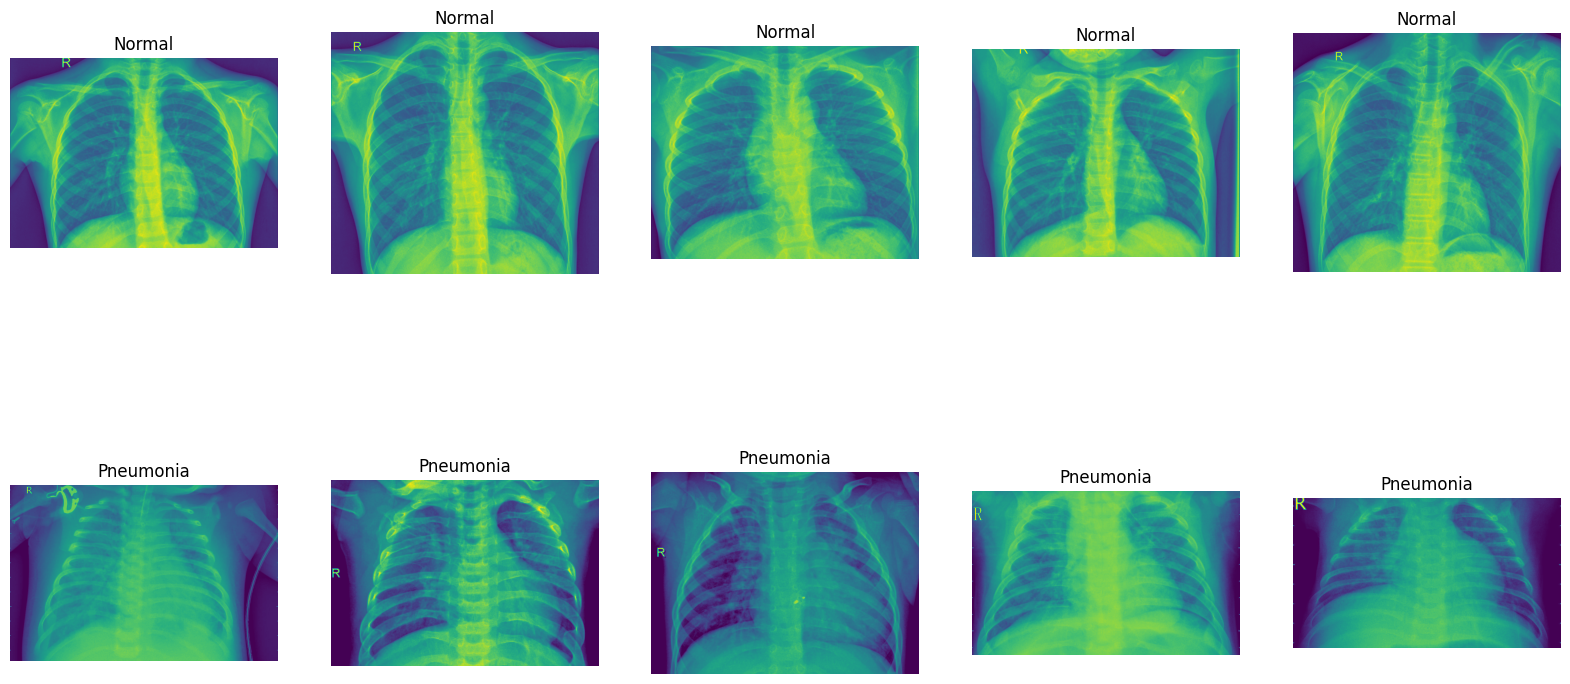

In [10]:
# Input features analysis
sample_size = 5
train_normal_path = os.path.join(new_dataset_path, "train", "NORMAL")
train_pneumonia_path = os.path.join(new_dataset_path, "train", "PNEUMONIA")
sample_train_normal = os.listdir(train_normal_path)[:sample_size]
sample_train_pneumonia = os.listdir(train_pneumonia_path)[:sample_size]

fig, axs = plt.subplots(2, sample_size, figsize=(20, 10))
for i, file in enumerate(sample_train_normal):
    img = Image.open(os.path.join(train_normal_path, file))
    axs[0, i].imshow(img) # Reminding that one-channel image are displayed in viridis colormap by default
    axs[0, i].axis('off')
    axs[0, i].set_title('Normal')

    # Convert to numpy array to get the number of channels too
    print(f"Normal image {i} shape: {np.array(img).shape}") # Results in (height, width), which means that these are grayscale images (one-channel images)

for i, file in enumerate(sample_train_pneumonia):
    img = Image.open(os.path.join(train_pneumonia_path, file))
    axs[1, i].imshow(img)
    axs[1, i].axis('off')
    axs[1, i].set_title('Pneumonia')
    print(f"Pneumonia image {i} shape: {np.array(img).shape}")

plt.show()


In [11]:
# Find out distribution of heights, widths, channels, aspect ratios, and max and min values for the images
def get_image_stats(path: str) -> tuple:
    """
    Get statistics for the images in the given path.
    
    Args:
        path (str): The path to the images.

    Returns:
        tuple: A tuple containing the (filenames, heights, widths, channels, aspect ratios, max values, min values) of the images.

    """
    filenames = os.listdir(path)
    heights = []
    widths = []
    channels = []
    aspect_ratios = []
    max_vals = []
    min_vals = []

    for file in filenames:
        img = Image.open(os.path.join(path, file))
        img_array = np.array(img)

        heights.append(img_array.shape[0])
        widths.append(img_array.shape[1])
        channels.append(img_array.shape[2] if len(img_array.shape) == 3 else 1)
        aspect_ratios.append(img_array.shape[1] / img_array.shape[0])
        max_vals.append(img_array.max())
        min_vals.append(img_array.min())

    return filenames, heights, widths, channels, aspect_ratios, max_vals, min_vals

normal_stats = get_image_stats(train_normal_path)
pneumonia_stats = get_image_stats(train_pneumonia_path)

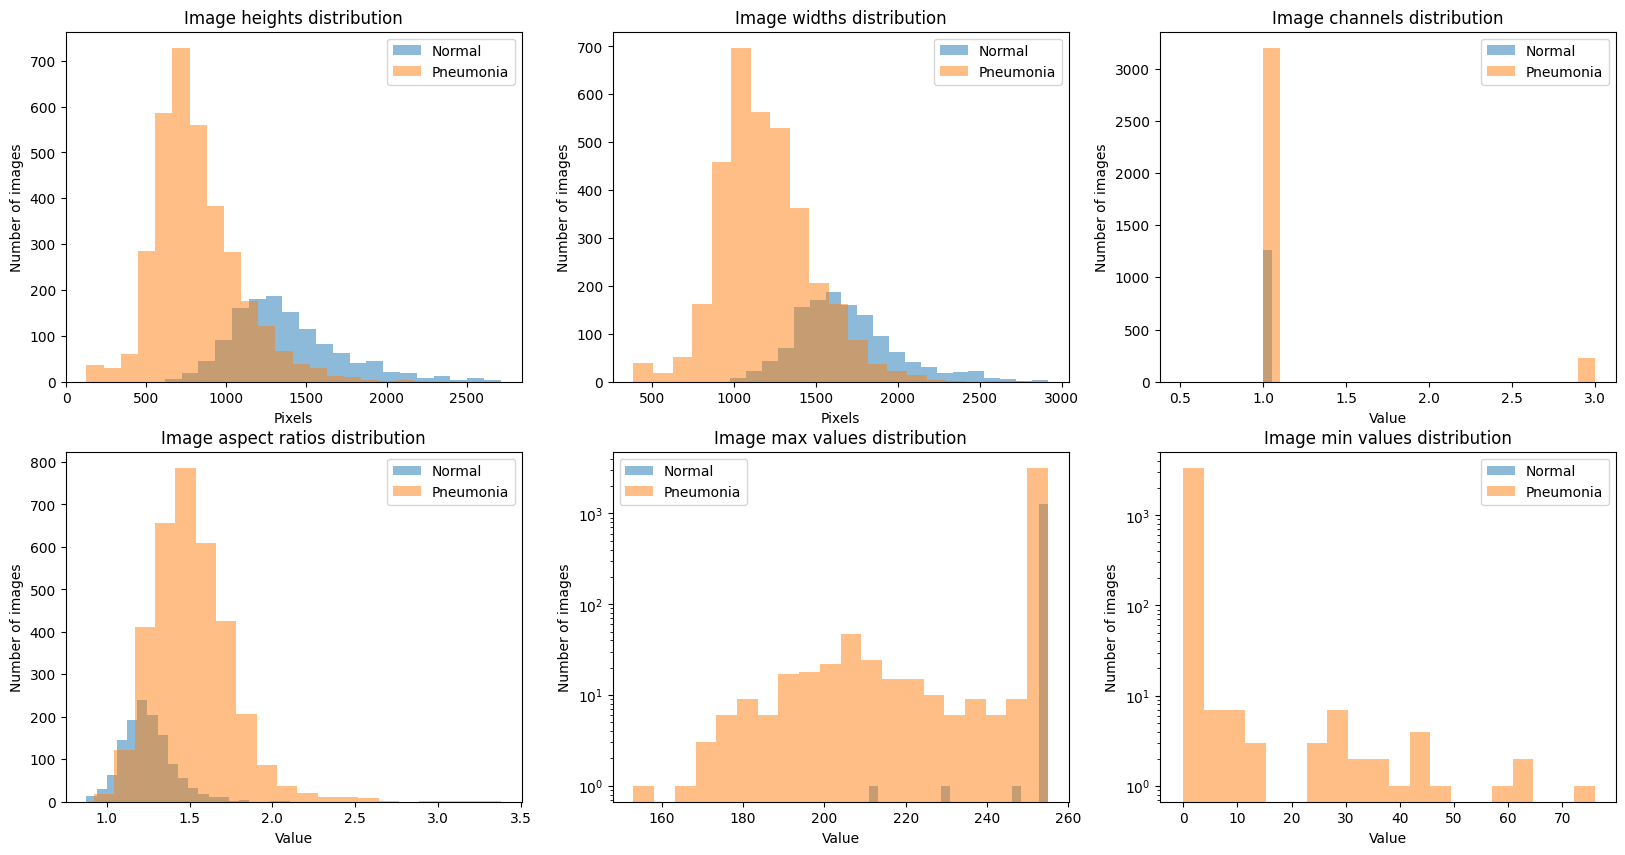

Height: mean = 967.28, std = 382.79
Width: mean = 1324.72, std = 361.99


In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

# Offset by 1
d = {0: "heights", 1: "widths", 2: "channels", 3: "aspect ratios", 4: "max values", 5: "min values"}

for i, v in d.items():
    axs[i//3, (i) % 3].hist(normal_stats[i+1], bins=20, alpha=0.5, label='Normal')
    axs[i//3, (i) % 3].hist(pneumonia_stats[i+1], bins=20, alpha=0.5, label='Pneumonia')
    # Log scale to better visualize the distribution with large y differences
    if i in (4, 5):
        axs[i//3, (i) % 3].set_yscale('log')
    axs[i//3, (i) % 3].set_xlabel('Pixels' if i in [0, 1] else 'Value')
    axs[i//3, (i) % 3].set_ylabel('Number of images')
    axs[i//3, (i) % 3].set_title(f'Image {v} distribution')
    axs[i//3, (i) % 3].legend()

plt.show()
print(f"Height: mean = {np.mean(normal_stats[1] + pneumonia_stats[1]):.2f}, std = {np.std(normal_stats[1] + pneumonia_stats[1]):.2f}")
print(f"Width: mean = {np.mean(normal_stats[2] + pneumonia_stats[2]):.2f}, std = {np.std(normal_stats[2] + pneumonia_stats[2]):.2f}")


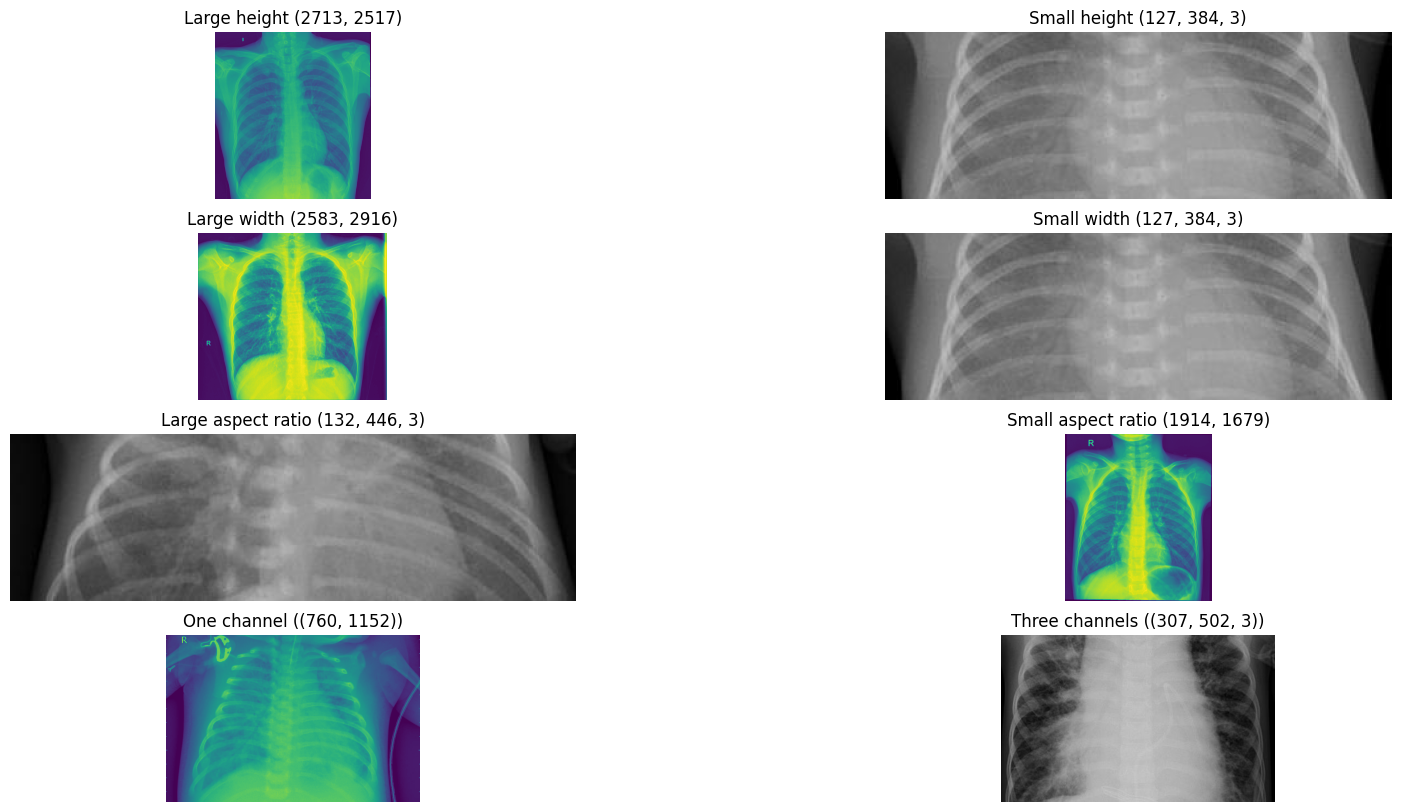

Number of images with 3 channels: 224


In [13]:
# Curious about  what a (large / small) (height / width / aspect ratio) look like. Also about the small proportion of images with 3 channels
# From heuristics of the graph, we can see that the small height, width, and large aspect ratio images are likely to be pneumonia images, while the large height, width, and small aspect ratio images are likely to be normal images
fig, axs = plt.subplots(4, 2, figsize=(20, 10))


large_height_filename = os.path.join(train_normal_path, normal_stats[0][np.argmax(normal_stats[1])])
small_height_filename = os.path.join(train_pneumonia_path, pneumonia_stats[0][np.argmin(pneumonia_stats[1])])

large_width_filename = os.path.join(train_normal_path, normal_stats[0][np.argmax(normal_stats[2])])
small_width_filename = os.path.join(train_pneumonia_path, pneumonia_stats[0][np.argmin(pneumonia_stats[2])])

large_aspect_ratio_filename = os.path.join(train_pneumonia_path, pneumonia_stats[0][np.argmax(pneumonia_stats[4])])
small_aspect_ratio_filename = os.path.join(train_normal_path, normal_stats[0][np.argmin(normal_stats[4])])

one_channel_file_indexes = np.where(np.array(pneumonia_stats[3]) == 1)[0]
one_channel_filename = os.path.join(train_pneumonia_path, pneumonia_stats[0][one_channel_file_indexes[0]])
three_channels_file_indexes = np.where(np.array(pneumonia_stats[3]) == 3)[0]
three_channels_filename = os.path.join(train_pneumonia_path, pneumonia_stats[0][three_channels_file_indexes[0]])

for i, (filename, title) in enumerate([
        (large_height_filename, 'Large height'), 
        (small_height_filename, 'Small height'), 
        (large_width_filename, 'Large width'), 
        (small_width_filename, 'Small width'), 
        (large_aspect_ratio_filename, 'Large aspect ratio'), 
        (small_aspect_ratio_filename, 'Small aspect ratio')
    ]):

    img = Image.open(os.path.join(train_normal_path, filename))
    axs[i//2, (i) % 2].imshow(img)
    axs[i//2, (i) % 2].axis('off')
    axs[i//2, (i) % 2].set_title(title + f" {np.array(img).shape}")

for i, (filename, title) in enumerate([
        (one_channel_filename, 'One channel'), 
        (three_channels_filename, 'Three channels')
    ]):

    img = Image.open(os.path.join(train_pneumonia_path, filename))
    axs[3, (i) % 2].imshow(img)
    axs[3, (i) % 2].axis('off')
    axs[3, (i) % 2].set_title(title + f" ({np.array(img).shape})")

plt.show()

print(f"Number of images with 3 channels: {len(three_channels_file_indexes)}")




#### Preface

Before you begin, here are some clarifications:
1. The references are appended at the end of the file.
2. To ensure readability, most of the training and validation outputs are cleared. The results are reorganised and described in each discussion section.
3. Individual improvements were addressed before combining them, despite their order of appearance in the file.

**(a)**

### Label Analysis

The Chest X-ray Pneumonia dataset consists of two labels: "NORMAL" and "PNEUMONIA", indicating the absence or presence of pneumonia, respectively. This setup categorises the task as a binary image classification, allowing labels to be encoded as 0 and 1 during data preparation.

A significant concern lies in the **imbalance** between these classes, with the ratio of normal to pneumonia cases approximately 27:73. This imbalance could cause the model to be biased towards the pneumonia class. Common strategies to address this include undersampling the pneumonia class, oversampling or augmenting the normal class, or applying class weights during training.

### Feature Analysis

The dataset features images, specifically their channel and pixel values. Initial observations reveal that the images consist of only one channel. The presence of a small "R" on the images -potentially indicating the left and right sides of the body— poses a caveat when considering data augmentation, as the "R" is asymmetrical and unsuitable for mirroring.

A more detailed examination reveals significant **heterogeneity** in image formats. Heights, widths, and aspect ratios vary widely; images labelled "normal" are generally larger and squarer, while "pneumonia" images tend to be smaller and less uniform. Minimum and maximum pixel values range between 0 and 255. Interestingly, a small subset of images contains **three channels**. These gray scale images appear to be three-channel images despite the expectation of one-channel data. Analysis suggests that this subset belongs to the pneumonia class, characterised by smaller dimensions, possibly capturing only the central chest area.

Converting three-channel images to one-channel is feasible without significant information loss since they are gray scale. Initially, we may consider removing images with excessively large or small dimensions to ensure uniformity. However, given that these images were curated and examined by experts (as described in the Kaggle data card), we will retain all images and apply resizing or rescaling techniques as needed, especially since the dataset size is manageable.

# Question 2: Data Preparation (5 marks)

Here, you should load the dataset into torch dataloaders, performing any preprocessing required in the process.

Within the ChestXrayDataset class, the root_dir parameter is a string defining the directory containing the "train", "val" and "test" folders.

In [26]:
# Set random seeds
random_seed = 28
np.random.seed(random_seed)
torch.manual_seed(random_seed)

dataset_path = "D:/datasets/ucl/chest_xray_dataset_new_split"
batch_size = 32

# Set desired image size
height = 224
width = 224


In [9]:
class ChestXrayDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.images = []
        self.labels = []
        for filename in os.listdir(os.path.join(root_dir, split, 'NORMAL')):
            self.images.append(os.path.join(root_dir, split, 'NORMAL', filename))
            self.labels.append(0)
        for filename in os.listdir(os.path.join(root_dir, split, 'PNEUMONIA')):
            self.images.append(os.path.join(root_dir, split, 'PNEUMONIA', filename))
            self.labels.append(1)

        self.images = np.array(self.images)
        self.labels = np.array(self.labels)

        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################
        image = Image.open(self.images[idx])
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

In [30]:
# Calculate mean and std of the dataset after proposed Grayscale, Resize, and ToTensor transformations
transform_prev = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((height, width)),
    transforms.ToTensor()
])

dataset = ChestXrayDataset(dataset_path, split='train', transform=transform_prev)
all_pixels = []
for i in range(len(dataset)):
    img, _ = dataset[i]
    all_pixels.append(img.view(-1))

all_pixels = torch.cat(all_pixels, dim=0)
mean = all_pixels.mean(dim=0)
std = all_pixels.std(dim=0)

print(f"Mean: {mean:.4f}")
print(f"Std: {std:.4f}")



Mean: 0.48126277327537537
Std: 0.23684284090995789


In [11]:
# Define data transforms
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################

def prepare_transforms(height: int, width: int) -> transforms:
    """
    Prepares the image transformation according to the given height and width.

    Args:
        height (int): The height of the image.
        width (int): The width of the image.

    Returns:
        transforms: The image transformation.
    """

    # Prepare dataloader
    transform_prev = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((height, width)),
        transforms.ToTensor()
    ])

    dataset = ChestXrayDataset(dataset_path, split='train', transform=transform_prev)
    all_pixels = []
    for i in range(len(dataset)):
        img, _ = dataset[i]
        all_pixels.append(img.view(-1))

    all_pixels = torch.cat(all_pixels, dim=0)
    mean = all_pixels.mean(dim=0)
    std = all_pixels.std(dim=0)

    image_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((height, width)),
        transforms.ToTensor(), # Also normalises the image to [0, 1]
        # Standardize the image to have mean 0 and standard deviation 1
        transforms.Normalize(mean=mean, std=std)
    ])

    return image_transform

        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

Train size: 4684
Val size: 585
Test size: 587
Image batch shape: torch.Size([32, 1, 224, 224])
Label batch shape: torch.Size([32])


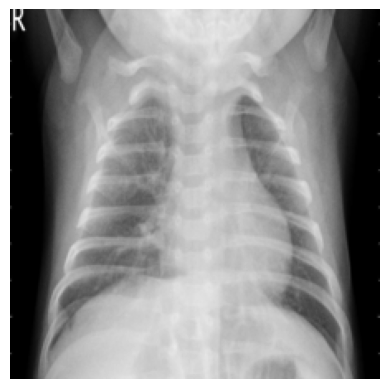

In [ ]:
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################

image_transform = prepare_transforms(height, width)

# Create datasets
train_dataset = ChestXrayDataset(dataset_path, split='train', transform=image_transform)
val_dataset = ChestXrayDataset(dataset_path, split='val', transform=image_transform)
test_dataset = ChestXrayDataset(dataset_path, split='test', transform=image_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

# Print dataset sizes
print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

# Print batch shapes
for images, labels in train_loader:
    print(f"Image batch shape: {images.size()}")
    print(f"Label batch shape: {labels.size()}")
    plt.figure()
    plt.imshow(images[0][0], cmap='gray')
    plt.axis('off')
    plt.show()
    break

**(a)**  

In terms of general settings, we first choose a fixed random seed to ensure the reproducibility of results. Next, we must determine the batch size and image size. Based on established heuristics, a batch size of 32 serves as a good starting point [1] [2] since it is large enough to provide stable gradient estimates without being too significant relative to validation and test sizes. For image size, we start with a heuristic of 224x224 pixels [3].

We opt for resizing rather than cropping and padding to offer a more uniform transformation. While cropping and padding might introduce unnecessary noise or exclude essential information, resizing —despite potentially distorting the aspect ratio— standardises the input.

Additionally, we convert three-channel images to one channel using the `Grayscale` transformation to ensure uniformity. As previously explained, this conversion minimally impacts the information content.

Finally, we perform normalisation to the range [0, 1] and standardisation to a mean of 0 and standard deviation of 1 to ensure more stable convergence and prevent exploding or vanishing gradients.

# Question 3: Training a Baseline (30 marks)

You will now establish an initial baseline model and training procedure. This should be as simple as possible, without using any elaborate design choices, whilst still obtaining reasonable performance (i.e., at least better than random chance). You will attempt to improve upon this baseline in later questions.

When answering this question, consider what makes a good baseline:
* Easily converges;
* Easy to implement;
* Established architectural components that have proved well suited to the data-type and problem.
* Obtains reasonable performance e.g, better than random guess

You will be required to explain your design choices, and to present and discuss you results.

The code below is a suggested structure to guide you. You are free to deviate from this __however, it must be obvious to the marker__:
* What the final proposed baseline model is (in terms of architecture);
* What the performance of the baseline model is and how the model has been trained;
* What your written justification and discussion is;



In [135]:
# Let's prepare all the configurations after definition cells

In [12]:
########################################################################
#                              YOUR CODE HERE                          #
########################################################################
# Define a model suitable for improvements
class FlexModel(nn.Module):
    def __init__(self, height: int, width: int, num_classes: int = 2, feature_maps: int = 32, kernel_size: int = 3, activation: nn.Module = nn.ReLU(), regularisation: bool = False, dropout: float = 0.5):
        super(FlexModel, self).__init__()
        self.conv = nn.Conv2d(1, feature_maps, kernel_size, padding=kernel_size // 2)
        self.batchnorm = nn.BatchNorm2d(feature_maps)
        self.activation = activation
        self.dropout = nn.Dropout(dropout)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(height * width * feature_maps, num_classes)

        self.regularisation = regularisation

    def forward(self, x):
        x = self.conv(x)
        if self.regularisation:
            x = self.batchnorm(x)
        x = self.activation(x)
        if self.regularisation:
            x = self.dropout(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x
########################################################################
#                             END OF YOUR CODE                         #
########################################################################


In [27]:
########################################################################
#                              YOUR CODE HERE                          #
########################################################################
# Will use multiple evaluation methods

# def calculate_class_accuracy(outputs, labels):
# It is hard to calculate accuracy when only one batch is passed. So we could make this function to calculate the confusion matrix instead
def calculate_confusion_matrix(outputs, labels) -> torch.Tensor:
        """"
        Calculate the confusion matrix for the given outputs and labels.
        
        Args:
                outputs (torch.Tensor): The model outputs.
                labels (torch.Tensor): The true labels.

        Returns:
                torch.Tensor: The confusion matrix in the format TP, FP, TN, FN.
        
        """
        
        # Get the predicted classes
        predictions = outputs.argmax(dim=1)

        # Get the true positive, false positive, true negative, and false negative counts
        tp = ((predictions == labels) & (labels == 1)).sum().item()
        fp = ((predictions != labels) & (labels == 0)).sum().item()
        tn = ((predictions == labels) & (labels == 0)).sum().item()
        fn = ((predictions != labels) & (labels == 1)).sum().item()

        return torch.tensor([tp, fp, tn, fn])

def model_report(model: nn.Module, data_loader: DataLoader, device: str, plot: bool=True) -> tuple:
    """
    Uses the model to perform predictions on data loader, reports and visualises the results. 
    Plots confusion matrix, ROC curve, and PR curve. Returns f1-score, ROC AUC, PR AUC, and accuracy.

    Args:
        model (nn.Module): The model to use for predictions.
        data_loader (DataLoader): The data loader to use for predictions.
        device (str): The device to use for predictions.

    Returns:
        float, float, float, float: The f1-score, ROC AUC, PR AUC, and accuracy of the model.
    """

    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(output.argmax(dim=1).cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    f1 = f1_score(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)
    accuracy = accuracy_score(y_true, y_pred)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if plot:
        plt.figure()
        plt.imshow(cm, cmap='Blues')
        plt.colorbar()
        plt.xticks([0, 1])
        plt.yticks([0, 1])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion matrix. F1-score: {f1:.4f}')
        for i in range(2):
            for j in range(2):
                plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
        plt.show()

    # ROC curve
        plt.figure()
        plt.plot(fpr, tpr, label = f'AUC: {roc_auc:.4f}', color='C1')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title(f'ROC curve')
        plt.legend()
        plt.show()

    # PR curve
        plt.figure()
        plt.plot(recall, precision, label = f'AUC: {pr_auc:.4f}', color='C2')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'PR curve')
        plt.legend()
        plt.show()
    

    return f1, roc_auc, pr_auc, accuracy

########################################################################
#                             END OF YOUR CODE                         #
########################################################################

In [ ]:
def single_train(model, train_loader, criterion, optimizer, device='cuda') -> tuple:
        model.train()
        total_loss = 0
        confusion_matrix = torch.zeros(4) # TP, FP, TN, FN

        for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                output = model(images)
                loss = criterion(output, labels)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                confusion_matrix += calculate_confusion_matrix(output, labels)

        total_loss /= len(train_loader)

        # Calculate the accuracy for each class and overall accuracy.
        # Class accuracy is defined by true class / prediction to this class, e.g. true positive / (true positive + false negative). Overall accuracy is defined by (true positive + true negative) / total.
        class_1_accuracy = confusion_matrix[0] / (confusion_matrix[0] + confusion_matrix[3])
        class_0_accuracy = confusion_matrix[2] / (confusion_matrix[1] + confusion_matrix[2])
        accuracy = (confusion_matrix[0] + confusion_matrix[2]) / confusion_matrix.sum()

        return total_loss, accuracy, torch.stack([class_0_accuracy, class_1_accuracy])


def validate(model, val_loader, criterion, device='cuda') -> tuple:
        model.eval()
        total_loss = 0
        confusion_matrix = torch.zeros(4) # TP, FP, TN, FN
        y_true = []
        y_pred = []

        for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                output = model(images)
                loss = criterion(output, labels)

                total_loss += loss.item()
                confusion_matrix += calculate_confusion_matrix(output, labels)

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(output.argmax(dim=1).cpu().numpy())

        total_loss /= len(val_loader)

        class_1_accuracy = confusion_matrix[0] / (confusion_matrix[0] + confusion_matrix[3])
        class_0_accuracy = confusion_matrix[2] / (confusion_matrix[1] + confusion_matrix[2])
        accuracy = (confusion_matrix[0] + confusion_matrix[2]) / confusion_matrix.sum()

        # F1 score, ROC AUC, and PR AUC
        f1 = f1_score(y_true, y_pred)
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        precision, recall, _ = precision_recall_curve(y_true, y_pred)
        pr_auc = auc(recall, precision)

        return total_loss, accuracy, torch.stack([class_0_accuracy, class_1_accuracy]), f1, roc_auc, pr_auc

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30, device='cuda', use_wandb=False, project_name='COMP0188_CW1', wandb_run_name='baseline', config=None, checkpoint_dirs="D:/cloud/Projects/ucl/DLR/cw1/checkpoint") -> tuple:

        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################

        if use_wandb:
                wandb.init(project=project_name, name=wandb_run_name,  config=config)
                wandb.watch(model)

        model.to(device)
        train_losses = []
        train_accuracies = []
        val_losses = []
        val_accuracies = []
        train_class_accuracies = [] # Each element is a tensor of size 2, representing the class accuracy for class 0 and class 1 respectively
        val_class_accuracies = []

        for epoch in range(num_epochs):
                train_loss, train_accuracy, train_class_accuracy = single_train(model, train_loader, criterion, optimizer, device)
                val_loss, val_accuracy, val_class_accuracy, f1, roc_auc, pr_auc = validate(model, val_loader, criterion, device)

                train_losses.append(train_loss)
                train_accuracies.append(train_accuracy)
                val_losses.append(val_loss)
                val_accuracies.append(val_accuracy)
                train_class_accuracies.append(train_class_accuracy)
                val_class_accuracies.append(val_class_accuracy)

                if use_wandb:
                        wandb.define_metric("best_loss", summary="min")
                        wandb.define_metric("best_accuracy", summary="max")
                        wandb.define_metric("best_f1", summary="max")
                        wandb.define_metric("best_roc_auc", summary="max")
                        wandb.define_metric("best_pr_auc", summary="max")
                        wandb.log({
                                'train_loss': train_loss,
                                'train_accuracy': train_accuracy,
                                'val_loss': val_loss,
                                'val_accuracy': val_accuracy,
                                'train_class_0_accuracy': train_class_accuracy[0],
                                'train_class_1_accuracy': train_class_accuracy[1],
                                'val_class_0_accuracy': val_class_accuracy[0],
                                'val_class_1_accuracy': val_class_accuracy[1],
                                'f1': f1,
                                'roc_auc': roc_auc,
                                'pr_auc': pr_auc,
                                
                                'best_loss': val_loss,
                                'best_accuracy': val_accuracy,
                                'best_f1': f1,
                                'best_roc_auc': roc_auc,
                                'best_pr_auc': pr_auc

                        })

                if epoch % 10 == 0:
                        print(f"Epoch {epoch}: Train accuracy: {train_accuracy*100:.2f}%, Val accuracy: {val_accuracy*100:.2f}%")

                if val_accuracy == max(val_accuracies):
                        if not os.path.exists(os.path.join(checkpoint_dirs, wandb_run_name)):
                                os.makedirs(os.path.join(checkpoint_dirs, wandb_run_name))
                                
                        torch.save({
                                'epoch': epoch,
                                'model_state_dict': model.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                'config': config,
                                'val_loss': val_loss,
                                'val_accuracy': val_accuracy,
                                'f1': f1,
                                'roc_auc': roc_auc,
                                'pr_auc': pr_auc
                        }, os.path.join(checkpoint_dirs, wandb_run_name, f'best_model.pth'))
                        print(f"Model saved at epoch {epoch} with validation accuracy {val_accuracy:.4f}")
        
        train_class_accuracies = torch.stack(train_class_accuracies)    
        val_class_accuracies = torch.stack(val_class_accuracies)

        if use_wandb:
                wandb.finish()

        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies


In [15]:
# wandb visualisations preferred, but still keep this function in hand
def plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies, name='baseline'):

        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################

        fig, axs = plt.subplots(4, 1, figsize=(10, 15))

        axs[0].plot(train_losses, label='Train')
        axs[0].plot(val_losses, label='Validation')
        axs[0].set_title(f'{name} Loss')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Loss')
        axs[0].legend()

        axs[1].plot(train_accuracies, label='Train')
        axs[1].plot(val_accuracies, label='Validation')
        axs[1].set_title(f'{name} Accuracy')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Accuracy')
        axs[1].legend()

        axs[2].plot(train_class_accuracies[:, 0], label='Train')
        axs[2].plot(val_class_accuracies[:, 0], label='Validation')
        axs[2].set_title(f'{name} Class 0 Accuracy')
        axs[2].set_xlabel('Epoch')
        axs[2].set_ylabel('Accuracy')
        axs[2].legend()

        axs[3].plot(train_class_accuracies[:, 1], label='Train')
        axs[3].plot(val_class_accuracies[:, 1], label='Validation')
        axs[3].set_title(f'{name} Class 1 Accuracy')
        axs[3].set_xlabel('Epoch')
        axs[3].set_ylabel('Accuracy')
        axs[3].legend()

        plt.tight_layout()
        plt.show()



        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

In [ ]:
########################################################################
# Hyperparameters and settings of the model
random_seed = 28
np.random.seed(random_seed)
torch.manual_seed(random_seed)
PROJECT_NAME = "COMP0188_CW1"
wandb_run_name = "flex_baseline"
checkpoint_dirs = "D:/cloud/Projects/ucl/DLR/cw1/checkpoint"
use_wandb = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 50 # Increased the number of epochs to 50	to capture overfitting

# List of controlled variables
height = 224
width = 224
batch_size = 32
feature_maps = 32
kernel_size = 3
lr = 0.001
activation = nn.ReLU()
loss_weighted = False
regularisation = False
dropout = 0.5

model = FlexModel(height, width, feature_maps=feature_maps, kernel_size=kernel_size, activation=activation, regularisation=regularisation, dropout=dropout).to(device)

In [ ]:
# Define loss function and optimizer
        ########################################################################
        #                              YOUR CODE HERE                          #
        ########################################################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################


In [132]:
# Prepare config
config = {
    "input_height": height,
    "input_width": width,
    "batch_size": batch_size,
    "feature_maps": feature_maps,
    "kernel_size": kernel_size,
    "learning_rate": lr,
    "activation": activation.__class__.__name__,
    "loss_function": criterion.__class__.__name__,
    "loss_weighted": loss_weighted,
    "optimizer": optimizer.__class__.__name__,
    "regularisation": regularisation,
    "dropout": dropout,
    "num_epochs": num_epochs,
    "random_seed": random_seed
}

config

{'input_height': 224,
 'input_width': 224,
 'batch_size': 32,
 'feature_maps': 32,
 'kernel_size': 3,
 'learning_rate': 0.001,
 'activation': 'ReLU',
 'loss_function': 'CrossEntropyLoss',
 'loss_weighted': False,
 'optimizer': 'SGD',
 'regularisation': False,
 'dropout': 0.5,
 'num_epochs': 50,
 'random_seed': 28}

In [ ]:
# Train the model
train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, device, use_wandb, PROJECT_NAME, wandb_run_name, config=config, checkpoint_dirs=checkpoint_dirs
)

# Plot training curves
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies)

In [ ]:
val_dataset = ChestXrayDataset(dataset_path, split='val', transform=prepare_transforms(height, width))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Evaluate the model
model.load_state_dict(torch.load(os.path.join(checkpoint_dirs, "flex_baseline", 'best_model.pth'))['model_state_dict'])
f1, roc_auc, pr_auc, accuracy = model_report(model, val_loader, device)

print(f"F1-score: {f1:.4f}, ROC AUC: {roc_auc:.4f}, PR AUC: {pr_auc:.4f}, Accuracy: {accuracy:.4f}")

**(a)**

#### Intuition

For image classification tasks, Convolutional Neural Networks (CNNs) are among the most suitable architectures. AlexNet, for example, demonstrated significant success in the 2012 ImageNet Challenge by employing a few CNN layers alongside thoughtful design choices [4]. Other architectures such as VGG and ResNet have also shown CNNs' capabilities in detecting patterns and edges in pneumonia chest X-ray images [3] [5]. Thus, for the baseline, we draw inspiration from these renowned CNN architectures and insights from literature reviews.

To summarise the code execution, the entire training procedure is roughly divided into the following steps:
1. Declaration of model hyperparameters and settings
2. Construction of the model, loss function, and optimiser
3. Model training
4. Plotting of training curves
5. Model evaluation

#### Model Architecture

The `FlexModel`, with arguments slightly adapted to incorporate subsequent improvements, features a single convolutional layer followed by a fully connected layer. An activation layer and a flatten layer are included as intermediaries to facilitate transitions. This simple, minimalistic architecture is expected to converge easily and allows straightforward implementation. The pooling layer is omitted as it reduces sample dimensions but isn't strictly necessary. Ultimately, this creates a strong foundational baseline for clear debugging and understanding.

#### Hyperparameter Choices

To ensure experiment reproducibility, random seeds are set. We also enable logging with Weights & Biases (wandb) to record results and visualise progress. The number of epochs is set to 50, ensuring the model learns fully until overfitting occurs; model weights are stored based on the best validation accuracy to revisit earlier epochs.

Input and batch sizes have been addressed previously. A critical hyperparameter in CNN layers is the number of feature maps or hidden layers. Here, we decide on an initial value of 32, balancing our computational resources and task complexity [6]. For kernel size, the VGG architecture has demonstrated the effectiveness of small kernel sizes, such as 3x3, in capturing patterns [7]. Literature examples also support this, including [6] [8].

In training, we use the ReLU (Rectified Linear Unit) activation function due to its computational efficiency, reliability, and mitigation of vanishing gradient issues [4] [7]. The learning rate is set at 0.001 to achieve stable yet not overly slow convergence [9] [10].

Finally, Cross-Entropy Loss (CEL) serves as the loss function. Accordingly, we use two output nodes in the final fully connected layer to correspond with the number of classes. Opting for standard CEL rather than Binary Cross-Entropy (BCE) with Sigmoid permits future multi-class classification extensions. Stochastic Gradient Descent (SGD) is chosen as the optimiser, representing the basic standard setup.

A note on data loaders: Standardisation transforms are dependent on pixel values post-resizing. Because these values vary with resize dimensions, new datasets and data loaders are recreated whenever heights and widths are adjusted.

**(b)**

The following plots are generated using Weights & Biases (WandB) and depict the training performance of the **baseline** model.

| ![Accuracy](img/baseline/accuracy.png) | ![Accuracy Zoomed](img/baseline/zoomed-accuracy.png) |
|-|-|
| ![Loss](img/baseline/loss.png) | ![Loss Zoomed](img/baseline/zoomed-loss.png) |
| ![Train Class Accuracy](img/baseline/train_class_accuracy.png) | ![Validation Class Accuracy](img/baseline/val_class_accuracy.png) |

Selecting the best model based on the epochs, the following metrics were evaluated on the validation dataset:

|Accuracy|F1-Score|ROC AUC|PR AUC|
|-|-|-|-|
| 0.9641 | 0.9754 | 0.9535 | 0.9840 |

Visual Metrics:

|Confusion Matrix|ROC Curve|PR Curve|
|-|-|-|
| ![Confusion Matrix](img/baseline/cm.png) | ![ROC Curve](img/baseline/roc.png) | ![PR Curve](img/baseline/pr.png) |




**(c)**

#### Plot and Metrics Explanation

We provide the accuracy (also zoomed), loss (also zoomed), and class accuracy relative to epochs. Accuracy reflects the evolution of correctly classified samples among all samples, whereas loss quantifies the loss function as empirical risk. The train and validation class accuracy for each label is also presented, as specified in the code.

For evaluation metrics, in addition to validation accuracy, we include F1-Score, ROC (Receiver Operating Characteristic) AUC (Area Under Curve), PR (Precision-Recall) AUC, and a Confusion Matrix. An important consideration is that validation accuracy may not adequately quantify model performance if class imbalance is present. Although we used validation accuracy as the goal metric during training, balance-insensitive metrics like F1-Score offer additional insights into model performance.

#### Results Discussion

With the plateauing of validation accuracy in later epochs, the model has fully exploited the dataset and its own capabilities. Beyond this point, although training accuracy continues to rise and loss decreases, validation metrics remain saturated.

In its best iteration, this baseline model achieves an accuracy of 96.41%, which is a respectable performance compared to previous literature on this dataset and task, e.g., [3] [6] [8] [10] [11]. The F1-Score, calculated as 2 * (Precision * Recall) / (Precision + Recall), is 0.9754, also notably high for a baseline model. This likely indicates that the task and dataset were not too complex to classify. Regarding the ROC and PR curves, we observe an elbow-like plot. This threshold effect suggests that while the model effectively separates classes, it struggles with challenging and edge cases. This difficulty might also arise from an uneven distribution of class types, which leads to a small overlap or inversion among them in the model's distribution space.

Finally, analysing the confusion matrix, we note 10 and 11 false negatives and positives, respectively. These likely represent cases where the model struggles with classification. Conversely, the baseline model still correctly classifies 417 pneumonia and 147 normal cases, marking a strong starting point.

# Question 4: Improving the Baseline (50 marks)
After analysing the results of your baseline, can you spot any clear areas for improvement, or think of any obvious improvements to your model and training setup that will improve performance?

You are free to try out as many improvements as you want here. You may also try modifying aspects of the data.

**However, for the final code and results you present in your submission, you should use exactly 3 design choices which (attempt to) improve upon the baseline.**

Tips:
* If you struggle to improve upon the baseline, but your design choices are well motivated and well implemented, and your results are well-presented and discussed, you will still receive most marks here. You will get some extra marks for improving upon baseline performance, but you will primarily be marked for making reasonable design choices.
* A small number of marks will be deducted if there are extremely obvious issues with the baseline that you do not attempt to address

## Q 4.1: Final improved model -- baseline + 3 improvements (20 marks)



You should now choose three final improvements. Explain them, implement them, train a model, and present and discuss the results.

Try to maximize performance with the final three improvements you choose (i.e., pick the three best improvements you found).

In [ ]:
# Implement the improvements and train the model in as many cells as you need.

########################################################################
#                              YOUR CODE HERE                          #
########################################################################

## Improved Model
For the final improved model, the following three improvements are made:
1. Weighted loss function
2. Regularisation
3. Hyperparameter Optimisation

In [ ]:
# Run sweep experiments for hyperparameter optimisation

random_seed = 28
np.random.seed(random_seed)
torch.manual_seed(random_seed)
PROJECT_NAME = "COMP0188_CW1_combined_sweep"
wandb_run_name = "combined_sweep"
checkpoint_dirs = "D:/cloud/Projects/ucl/DLR/cw1/checkpoint/combined_sweep"
use_wandb = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 20 # Reduced epochs to focus on faster exploration

# List of hyperparameters to sweep
# heights = [224, 64, 512, 300]
# widths = [224, 64, 512, 300]
input_sizes = [(224, 224), (64, 64), (512, 512), (300, 300)]
batch_sizes = [32, 16, 8, 64]
feature_maps = [16, 32, 64]
kernel_size = [3, 5, 7]
lr = (0.001, 0.00001) # Continuous hyperparameter
activation = ["ReLU", "LeakyReLU"] # Stringfy the activation function
optimizers = ["SGD", "Adam"] # Stringfy the optimizers
loss_weighted = True
regularisation = True
dropouts = (0.25, 0.75) # Continuous hyperparameter

# Weighted class criterion
weights_normal = 1 / stats['train']['NORMAL']
weights_pneumonia = 1 / stats['train']['PNEUMONIA']
total = weights_normal + weights_pneumonia
weights_normal, weights_pneumonia = weights_normal / total, weights_pneumonia / total # Normalise the weights
class_weights = [weights_normal, weights_pneumonia]

In [113]:
# Define a sweep run digest function
sweep_index = 0
def sweep_run():
    global sweep_index
    sweep_index += 1
    wandb_run_name = f"sweep_{sweep_index}"

    # Variables from sweep run
    wandb.init()
    config = wandb.config
    if "wandb_run_name" in config:
        wandb_run_name = config["wandb_run_name"]

    height, width = config.input_size
    batch_size = config.batch_size
    feature_maps = config.feature_maps
    kernel_size = config.kernel_size
    lr = config.lr
    activation = nn.ReLU() if config.activation == "ReLU" else nn.LeakyReLU()
    _optimizer = optim.SGD if config.optimizer == "SGD" else optim.Adam
    regularisation = config.regularisation
    dropout = config.dropout
    loss_weighted = config.loss_weighted
    class_weights = torch.tensor(config.class_weights).to(device)


    # Data transforms
    image_transform = prepare_transforms(height, width)
    print("Finished data transforms")

    # Create datasets
    train_dataset = ChestXrayDataset(dataset_path, split='train', transform=image_transform)
    val_dataset = ChestXrayDataset(dataset_path, split='val', transform=image_transform)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Model
    model = FlexModel(height, width, feature_maps=feature_maps, kernel_size=kernel_size, activation=activation, regularisation=regularisation, dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights) if loss_weighted else nn.CrossEntropyLoss()
    optimizer = _optimizer(model.parameters(), lr=lr)

    # Config list
    config = {
        "input_height": height,
        "input_width": width,
        "batch_size": batch_size,
        "feature_maps": feature_maps,
        "kernel_size": kernel_size,
        "learning_rate": lr,
        "activation": activation.__class__.__name__,
        "loss_function": criterion.__class__.__name__,
        "loss_weighted": loss_weighted,
        "optimizer": optimizer.__class__.__name__,
        "regularisation": regularisation,
        "dropout": dropout,
        "num_epochs": num_epochs,
        "random_seed": random_seed
    }

    # Train the model
    train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, num_epochs, device, use_wandb, PROJECT_NAME, wandb_run_name, config=config, checkpoint_dirs=checkpoint_dirs
    )

    # Evaluate the model
    model.load_state_dict(torch.load(os.path.join(checkpoint_dirs, wandb_run_name, 'best_model.pth'))['model_state_dict'])
    f1, roc_auc, pr_auc, accuracy = model_report(model, val_loader, device, plot=False)

    print(f"F1-score: {f1:.4f}, ROC AUC: {roc_auc:.4f}, PR AUC: {pr_auc:.4f}, Accuracy: {accuracy:.4f}")
    print("-"*50)

    wandb.finish()
    

In [43]:
# Prepare a sweep configuration to search over the hyperparameters
sweep_num = 15
sweep_config = {
    'method': 'random',
    'metric': {
        'goal': 'maximize',
        'name': 'val_accuracy'
    },
    'parameters': {
        'input_size': {'values': input_sizes},
        'batch_size': {'values': batch_sizes},
        'feature_maps': {'values': feature_maps},
        'kernel_size': {'values': kernel_size},
        'lr': {'min': lr[1], 'max': lr[0]},
        'activation': {'values': activation},
        'optimizer': {'values': optimizers},
        'dropout': {'min': dropouts[0], 'max': dropouts[1]},
        'regularisation': {'values': [regularisation]},
        'loss_weighted': {'values': [loss_weighted]},
        'class_weights': {'values': [class_weights]},
    }
}

In [ ]:
# Run the sweep
sweep_id = wandb.sweep(sweep_config, project=PROJECT_NAME)

finished_sweeps = 0
sweep_index = finished_sweeps
wandb.agent(sweep_id, function=sweep_run, count=sweep_num-finished_sweeps)



In [ ]:
########################################################################
# Implement best set of hyperparameters given sweep experiment
random_seed = 28
np.random.seed(random_seed)
torch.manual_seed(random_seed)
PROJECT_NAME = "COMP0188_CW1"
wandb_run_name = "finetuned_improved"
checkpoint_dirs = "D:/cloud/Projects/ucl/DLR/cw1/checkpoint"
use_wandb = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 50 # Increased the number of epochs to 50	to capture overfitting

# List of hyperparameters
height = 300
width = 300
batch_size = 64
feature_maps = 16
kernel_size = 5
lr = 0.0003588
activation = "LeakyReLU"
optimizer = "Adam"
loss_weighted = True
regularisation = True
dropout = 0.6978

# Create datasets
train_dataset = ChestXrayDataset(dataset_path, split='train', transform=prepare_transforms(height, width))
val_dataset = ChestXrayDataset(dataset_path, split='val', transform=prepare_transforms(height, width))

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = FlexModel(height, width, feature_maps=feature_maps, kernel_size=kernel_size, activation=nn.LeakyReLU(), regularisation=regularisation, dropout=dropout).to(device)

In [123]:
sweep_config = {
    'name': wandb_run_name,
    'method': 'random',
    'metric': {
        'goal': 'maximize',
        'name': 'val_accuracy'
    },
    'parameters': {
        'input_size': {'value': [height, width]},
        'batch_size': {'value': batch_size},
        'feature_maps': {'value': feature_maps},
        'kernel_size': {'value': kernel_size},
        'lr': {'value': lr},
        'activation': {'value': activation},
        'optimizer': {'value': optimizer},
        'dropout': {'value': dropout},
        'regularisation': {'value': regularisation},
        'loss_weighted': {'value': loss_weighted},
        'class_weights': {'value': class_weights},
        'wandb_run_name': {'value': wandb_run_name}
    }
}

In [ ]:
# Run the sweep with final improved hyperparameters
sweep_id = wandb.sweep(sweep_config, project=PROJECT_NAME)

wandb.agent(sweep_id, function=sweep_run, count=1)

In [ ]:
# Evaluate the model
model.load_state_dict(torch.load(os.path.join(checkpoint_dirs, wandb_run_name, 'best_model.pth'))['model_state_dict'])

f1, roc_auc, pr_auc, accuracy = model_report(model, val_loader, device)

print(f"F1-score: {f1:.4f}, ROC AUC: {roc_auc:.4f}, PR AUC: {pr_auc:.4f}, Accuracy: {accuracy:.4f}")

**(a)**

The three improvements incorporated are weighted classes, regularisation, and hyperparameter optimisation (HPO).

#### Weighted Classes

The motivation for using weighted classes stems from the class imbalance identified during data exploration and analysis. Data imbalance can lead to biased models, such as a tendency to predict the pneumonia class more frequently because it appears more often in random sampling. We also observed unstable validation class accuracy, particularly for the pneumonia class. To prevent the model from favouring the majority class over the minority class, common solutions include weighted classes, data augmentation, and oversampling. Here, we choose to employ weighted classes by introducing weights in the loss function, increasing the importance of the minority class (normal) and decreasing it for the majority class (pneumonia). This approach has been proven effective in similar chest X-ray contexts [13].

Why not choose undersampling? Because the dataset has been carefully curated by experts, as described on the [Kaggle website](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia). Weighted classes are favoured over data augmentation because they are computationally less expensive, which is important when resources and time are limited. Additionally, some X-rays have an "R" marking to indicate body direction, and augmenting with symmetry and rotation risks losing this information.

#### Regularisation

Regularisation enhances the robustness and generalisability of the model while combating overfitting, which is crucial with relatively small datasets like medical imaging [12]. We implement this by adding batch normalisation after the convolutional layer and a dropout layer before the fully connected layer.

Initially, regularisation might seem redundant for a simple model that may be less prone to overfitting. However, medical images typically have high variability and can easily overfit to noise [14] [15]. Moreover, the baseline model's train accuracy increases while the loss decreases across all epochs, whereas validation metrics saturate early, indicating a need for increased robustness and generalisability. We also observed large fluctuations in validation accuracy and loss, especially early on and to some degree even at epochs 40+, marked notably in validation class accuracy. Hence, regularisation is intended to stabilise learning and speed up convergence. Despite uncertainties, regularisation is tested to empirically assess its impact, whether positive or negative.

#### Hyperparameter Optimisation

Hyperparameter optimisation (HPO) is a standard method to improve baseline model performance by selecting an optimal set of hyperparameters. We conduct HPO by initially sweeping over a set of candidate values and experimenting with random combinations. A more detailed sweep usually follows identifying the best configurations, but due to time constraints, only a general sweep is performed. The improved model is then trained using the best and most convincing settings.

The hyperparameters and candidates are:
- Input size (square height and width): [(224, 224), (64, 64), (512, 512), (300, 300)]
- Batch size: [32, 16, 8, 64]
- Number of feature maps: [16, 32, 64]
- Kernel size (square kernels, stride 1, padding size//2): [3, 5, 7]
- Learning rate: from 0.001 to 0.00001
- Activation function: ReLU or LeakyReLU
- Optimiser: SGD or Adam
- Dropout rate: from 0.25 to 0.75

The candidates are based on prior literature knowledge and insights from previous research on general or similar tasks [3] [4] [6] [8] [9] [10] [11] [16].

##### Additional Hyperparameter Tuning

As the *final improved* model exhibited unstable convergence, we attempted to address this by increasing the batch size from 8 to 64. Given that the learning rate is already low, batch normalisation and Adam are used, the activation is from the ReLU family, and proper shuffling and preprocessing are done.

**(b)**

From these 15 sweeps:

![Sweep Results](img/final_improved/sweep.png)

We identified some outstanding combinations:

![Sweep Selection Results](img/final_improved/sweep_selection.png)

The accuracies over epochs for these combinations are:

![Accuracy of Sweep Selection](img/final_improved/sweep_selection-accuracy.png)

After using the setting of:
- Input size: 300
- Batch size: 8
- Number of feature maps: 16
- Kernel size: 5
- Learning rate: 0.0003588
- Activation function: LeakyReLU
- Optimiser: Adam
- Dropout rate: 0.6978

The resulting model, called **final_improved**, has the following training plots:

| ![Accuracy](img/final_improved/final_improved-accuracy.png) | ![Accuracy Zoomed](img/final_improved/final_improved-accuracy_zoomed.png) |
|-|-|
| ![Loss](img/final_improved/final_improved-loss.png) | ![Loss Zoomed](img/final_improved/final_improved-loss_zoomed.png) |
| ![Train Class Accuracy](img/final_improved/final_improved-train_class_accuracy.png) | ![Validation Class Accuracy](img/final_improved/final_improved-val_class_accuracy.png) |

However, high fluctuations were observed when trying to achieve convergence. Therefore, we tuned the hyperparameters by increasing the batch size from 8 to 64. This is the **finetuned_improved** model:

| ![Accuracy](img/final_improved/finetuned_improved-accuracy.png) | ![Accuracy Zoomed](img/final_improved/finetuned_improved-accuracy_zoomed.png) |
|-|-|
| ![Loss](img/final_improved/finetuned_improved-loss.png) | ![Loss Zoomed](img/final_improved/finetuned_improved-loss_zoomed.png) |
| ![Train Class Accuracy](img/final_improved/finetuned_improved-train_class_accuracy.png) | ![Validation Class Accuracy](img/final_improved/finetuned_improved-val_class_accuracy.png) |


Selecting the best model among the epochs from **finetuned_improved**, these are the metrics after evaluation on the validation dataset:

|Model|Accuracy|F1-Score|ROC AUC|PR AUC|
|-|-|-|-|-|
| Baseline | 0.9641 | 0.9754 | 0.9535 | 0.9840 |
| Finetuned Improved | 0.9692 | 0.9787 | 0.9690 | 0.9899 |

Visual Metrics:

|Confusion Matrix|ROC Curve|PR Curve|
|-|-|-|
| ![Confusion Matrix](img/final_improved/cm.png) | ![ROC Curve](img/final_improved/roc.png) | ![PR Curve](img/final_improved/pr.png) |


**(c)**

We present the results of the **final_improved**, **finetuned_improved**, and **baseline** performance comparison. The best combination identified from the sweep, based on sweep 9, exhibited the best historical accuracy. However, from the sweep accuracy plot to the final accuracy and loss training plot, we note a lack of stability in convergence, characterised by large spikes. Consequently, the model's batch size was fine-tuned to 64 in hopes of stabilising convergence.

As a result, the **finetuned_improved** model still showed considerable variation during training, but, notably, its loss significantly decreased compared to the previous **final_improved** model. While we cannot definitively explain this phenomenon, it could potentially result from incompatible hyperparameter combinations, excessive regularisation leading to underfitting, or inadequate weight initialisation.

Despite these issues, the finetuned improved model demonstrated a higher validation accuracy (96.92%) than the baseline (96.41%). It is important to consider that such a small performance increase might be attributed to randomness in the model and data. An interesting observation is that the baseline's loss was significantly lower than that of the improved models during training. This can occur when labels are correctly classified but with low confidence. A positive interpretation is that edge cases are shifting from high-confidence misclassifications to low-confidence correct classifications. Conversely, this could also mean that the correct boundaries between classes are becoming ambiguous. For the other three metrics, small but positive increases are observed, suggesting that although performance may not be substantial but exists.

Regarding the confusion matrix, compared to the baseline, there's a notable decrease in false positives (from 11 to 5), albeit with some increase in false negatives (from 10 to 13). This indicates a reduced tendency to classify cases as pneumonia, suggesting a shift in class balance. However, the consequences of missing a patient must be considered, raising the question of whether this model performs better in real medical applications.

Finally, as we explore in the following sections, this model with combined improvements may not outperform models with individual improvements, which initially seems perplexing. One possible explanation is the entangled effects among the improvements, potentially diminishing overall model performance. This intriguing result invites further investigation into the complex interactions between design choices.

## Q 4.2: Empirically justify improvement 1 (10 marks)

Now you will empirically demonstrate the contribution of each improvement to the final performance of your model.

To justify the utility of an improvement, you should present one of the following experiments:
- *Option 1:* Train the final model _without_ that improvement (but still with the other two improvements). Compare these results to the results you presented previously with all three improvements. If the improvement is useful, removing it should result in a drop in performance
- *Option 2:* Compare the performance of baseline to the perfroamnce of the baseline plus a single improvement. If the improvement is useful, you should expect improved performance versus the baseline.

You will still get a significant portion of the marks if the proposed improvement was well-motivated but does not empirically improve perfromance. In this case, ensure your discussion touches on why performance may not have improved or any other interesting talking points.


In [121]:
# Implement the experiment in as many cells as you need.

########################################################################
#                              YOUR CODE HERE                          #
########################################################################

In [ ]:
########################################################################
# Run weighted class experiment
random_seed = 28
np.random.seed(random_seed)
torch.manual_seed(random_seed)
PROJECT_NAME = "COMP0188_CW1"
wandb_run_name = "weighted_class"
checkpoint_dirs = "D:/cloud/Projects/ucl/DLR/cw1/checkpoint"
use_wandb = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 50 # Increased the number of epochs to 50	to capture overfitting

# List of controlled variables
height = 224
width = 224
batch_size = 32
feature_maps = 32
kernel_size = 3
lr = 0.001
activation = nn.ReLU()
regularisation = False
dropout = 0.5

# List of independent variables
loss_weighted = True

# Create datasets
train_dataset = ChestXrayDataset(dataset_path, split='train', transform=prepare_transforms(height, width))
val_dataset = ChestXrayDataset(dataset_path, split='val', transform=prepare_transforms(height, width))

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = FlexModel(height, width, feature_maps=feature_maps, kernel_size=kernel_size, activation=activation, regularisation=regularisation, dropout=dropout).to(device)
# criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)


In [136]:
# Weighted class criterion
weights_normal = 1 / stats['train']['NORMAL']
weights_pneumonia = 1 / stats['train']['PNEUMONIA']
total = weights_normal + weights_pneumonia
weights_normal, weights_pneumonia = weights_normal / total, weights_pneumonia / total # Normalise the weights
class_weights = torch.tensor([weights_normal, weights_pneumonia]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

print(f"Class weights: {class_weights}")

Class weights: tensor([0.7297, 0.2703], device='cuda:0')


In [137]:
# Prepare config
config = {
    "input_height": height,
    "input_width": width,
    "batch_size": batch_size,
    "feature_maps": feature_maps,
    "kernel_size": kernel_size,
    "learning_rate": lr,
    "activation": activation.__class__.__name__,
    "loss_function": criterion.__class__.__name__,
    "loss_weighted": loss_weighted,
    "optimizer": optimizer.__class__.__name__,
    "regularisation": regularisation,
    "dropout": dropout,
    "num_epochs": num_epochs,
    "random_seed": random_seed
}

config

{'input_height': 224,
 'input_width': 224,
 'batch_size': 32,
 'feature_maps': 32,
 'kernel_size': 3,
 'learning_rate': 0.001,
 'activation': 'ReLU',
 'loss_function': 'CrossEntropyLoss',
 'loss_weighted': True,
 'optimizer': 'SGD',
 'regularisation': False,
 'dropout': 0.5,
 'num_epochs': 50,
 'random_seed': 28}

In [ ]:
# Train the model
train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, device, use_wandb, PROJECT_NAME, wandb_run_name, config=config, checkpoint_dirs=checkpoint_dirs
)

# Plot training curves
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies)

In [ ]:
# Evaluate the model
model.load_state_dict(torch.load(os.path.join(checkpoint_dirs, "weighted_class", 'best_model.pth'))['model_state_dict'])
f1, roc_auc, pr_auc, accuracy = model_report(model, val_loader, device)

print(f"F1-score: {f1:.4f}, ROC AUC: {roc_auc:.4f}, PR AUC: {pr_auc:.4f}, Accuracy: {accuracy:.4f}")

**(a)**

The overall strategy for proving the effectiveness of improvements involves comparing models with individual improvements against the baseline. Meaning, we opted for Option 2.

Before applying the loss function, we calculate the weights for each class. This is achieved by determining the inverse frequency of each class in the training data, followed by normalisation by dividing the sum of these frequencies. Without normalisation, the weights become very small (e.g., 1/3418), which could excessively reduce the loss and gradient, potentially hindering convergence. After normalisation, the class weights are 0.7297 for the Normal class and 0.2703 for the Pneumonia class. This essentially normalises the frequency ratio, flipped between the classes. These weights allow the minority class (Normal) to incur a larger loss when misclassified, helping to rebalance the classes.

To apply this, the class weights are introduced in `nn.CrossEntropyLoss(weights=)` as the `weights` argument.

**(b)**

The resulting model, called **weighted_class** has the following training plots:

| ![Accuracy](img/weighted_class/accuracy.png) | ![Accuracy Zoomed](img/weighted_class/accuracy_zoomed.png) |
|-|-|
| ![Loss](img/weighted_class/loss.png) | ![Loss Zoomed](img/weighted_class/loss_zoomed.png) |
| ![Train Class Accuracy](img/weighted_class/train_class_accuracy.png) | ![Validation Class Accuracy](img/weighted_class/val_class_accuracy.png) |


Taking the best model among the epochs from **weighted_class**, these are the metrics after evaluation on validation dataset.

|Model|Accuracy|F1-Score|ROC AUC|PR AUC|
|-|-|-|-|-|
| Baseline | 0.9641 | 0.9754 | 0.9535 | 0.9840 |
| Finetuned Improved | 0.9692 | 0.9787 | 0.9690 | 0.9899 |
| Weighted Class | 0.9658 | 0.9767 | 0.9507 | 0.9828 |


Visual Metrics:

|Confusion Matrix|ROC Curve|PR Curve|
|-|-|-|
| ![Confusion Matrix](img/weighted_class/cm.png) | ![ROC Curve](img/weighted_class/roc.png) | ![PR Curve](img/weighted_class/pr.png) |

**(c)**

The first observation is that the training plots do not exhibit a substantial difference between the baseline and the weighted class model. Their accuracy and loss progression appear very similar. Even when the weighted class model's validation accuracy exceeds the baseline in certain epochs, it may be arbitrary rather than indicative of a genuine increase.

The other three evaluation metrics show a slight improvement over the baseline while slightly underperforming compared to the combined improved model. This trend is logical since the weighted class model has fewer enhancements than the combined model but is an improvement over the baseline.

An interesting observation can be made from the confusion matrix. Compared to the baseline, there are more predictions for pneumonia in the weighted class model. This might be because the baseline model had already learned the patterns well, and the weighted class approach may have overfit the Normal class. It is also possible that the weighted loss did not effectively adjust the decision boundary; the weights might not have provided sufficient penalty. Furthermore, if the Normal class contained noisy data, such as mislabeled or ambiguous samples, this adjustment could inadvertently intensify the model's focus on these samples.

Overall, while the improvement is not significant, it is a positive advancement over the baseline.

## Q 4.3: Empirically justify improvement 2 (10 marks)

In [88]:
# Implement the experiment in as many cells as you need.

########################################################################
#                              YOUR CODE HERE                          #
########################################################################



In [ ]:
########################################################################
# Run regularisation experiment
random_seed = 28
np.random.seed(random_seed)
torch.manual_seed(random_seed)
PROJECT_NAME = "COMP0188_CW1"
wandb_run_name = "regularisation"
checkpoint_dirs = "D:/cloud/Projects/ucl/DLR/cw1/checkpoint"
use_wandb = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 50 # Increased the number of epochs to 50	to capture overfitting

# List of controlled variables
height = 224
width = 224
batch_size = 32
feature_maps = 32
kernel_size = 3
lr = 0.001
activation = nn.ReLU()
dropout = 0.5
loss_weighted = False

# List of independent variables
regularisation = True

# Create datasets
train_dataset = ChestXrayDataset(dataset_path, split='train', transform=prepare_transforms(height, width))
val_dataset = ChestXrayDataset(dataset_path, split='val', transform=prepare_transforms(height, width))

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = FlexModel(height, width, feature_maps=feature_maps, kernel_size=kernel_size, activation=activation, regularisation=regularisation, dropout=dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [140]:
# Prepare config
config = {
    "input_height": height,
    "input_width": width,
    "batch_size": batch_size,
    "feature_maps": feature_maps,
    "kernel_size": kernel_size,
    "learning_rate": lr,
    "activation": activation.__class__.__name__,
    "loss_function": criterion.__class__.__name__,
    "loss_weighted": loss_weighted,
    "optimizer": optimizer.__class__.__name__,
    "regularisation": regularisation,
    "dropout": dropout,
    "num_epochs": num_epochs,
    "random_seed": random_seed
}

config

{'input_height': 224,
 'input_width': 224,
 'batch_size': 32,
 'feature_maps': 32,
 'kernel_size': 3,
 'learning_rate': 0.001,
 'activation': 'ReLU',
 'loss_function': 'CrossEntropyLoss',
 'loss_weighted': False,
 'optimizer': 'SGD',
 'regularisation': True,
 'dropout': 0.5,
 'num_epochs': 50,
 'random_seed': 28}

In [ ]:
# Train the model
train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, device, use_wandb, PROJECT_NAME, wandb_run_name, config=config, checkpoint_dirs=checkpoint_dirs
)

# Plot training curves
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies)

In [ ]:
# Evaluate the model
model.load_state_dict(torch.load(os.path.join(checkpoint_dirs, "regularisation", 'best_model.pth'))['model_state_dict'])
f1, roc_auc, pr_auc, accuracy = model_report(model, val_loader, device)

print(f"F1-score: {f1:.4f}, ROC AUC: {roc_auc:.4f}, PR AUC: {pr_auc:.4f}, Accuracy: {accuracy:.4f}")

**(a)**

The motivation for regularisation has been detailed in previous sections. The implementation is divided into two parts: batch normalisation after the convolutional layer and the dropout layer before the fully connected layer, which helps prevent overfitting [17]. A dropout rate of 0.5 is a common starting point.

Batch normalisation normalises the internal feature space, accelerating convergence and improving stability during training. In contrast, the dropout layer randomly deactivates a proportion of neurons in the network, simulating the loss of part of the information. The model is compelled to learn patterns even with randomly deactivated neurons, reducing the model's capacity during training to enhance robustness and generalisability.

**(b)**

The resulting model, called **regularisation**, has the following training plots:

| ![Accuracy](img/regularisation/accuracy.png) | ![Accuracy Zoomed](img/regularisation/accuracy_zoomed.png) |
|-|-|
| ![Loss](img/regularisation/loss.png) | ![Loss Zoomed](img/regularisation/loss_zoomed.png) |
| ![Train Class Accuracy](img/regularisation/train_class_accuracy.png) | ![Validation Class Accuracy](img/regularisation/val_class_accuracy.png) |


Taking the best model among the epochs from **regularisation**, these are the metrics after evaluation on validation dataset.

|Model|Accuracy|F1-Score|ROC AUC|PR AUC|
|-|-|-|-|-|
| Baseline | 0.9641 | 0.9754 | 0.9535 | 0.9840 |
| Finetuned Improved | 0.9692 | 0.9787 | 0.9690 | 0.9899 |
| Regularisation | 0.9692 | 0.9790 | 0.9590 | 0.9858 |


Visual Metrics:

|Confusion Matrix|ROC Curve|PR Curve|
|-|-|-|
| ![Confusion Matrix](img/regularisation/cm.png) | ![ROC Curve](img/regularisation/roc.png) | ![PR Curve](img/regularisation/pr.png) |

**(c)**

Interestingly, the first impression of the regularisation training plot is the abrupt peaks in early epochs, particularly at epoch 11, marked by a huge validation loss and a drop in validation accuracy. During this epoch, the validation accuracy for the normal class almost reached 0, and for the pneumonia class, it tended towards 1. Considering that normal class accuracy is TN/(TN+FP) and pneumonia class accuracy is TP/(TP+FN), the TP and FP were probably very high while TN and FN were nearly absent, indicating that most samples were classified as pneumonia. This could be due to an unfortunate combination of parameters in that epoch.

After passing that point, train accuracy and loss noticeably outperformed the baseline's training curves. However, this did not translate to better validation performance. A noteworthy observation is that the gap between training and validation loss is larger than in the baseline model. Despite this, validation accuracy did see a slight increase, from 96.41% to 96.92%. Although potentially trivial, this accuracy matches that of the combined improved model.

The regularisation model also outperforms the baseline in the other three metrics, including a better F1-Score than the combined improved model. The reason lies in the confusion matrix. We observe that both FP and FN are lower than in the baseline confusion matrix (from 11 to 10 and 10 to 8, respectively). This presents a more balanced view compared to the combined improved model's decrease (lower FP but higher FN), leading to a higher F1-Score with the same accuracy. This balance is a more desirable model outcome in general.

In conclusion, regularisation slightly outperformed the baseline model and achieved a better balance between misclassified samples.

## Q 4.4: Empirically justify improvement 3 (10 marks)

In [ ]:
# Implement the experiment in as many cells as you need.

########################################################################
#                              YOUR CODE HERE                          #
########################################################################


In [ ]:
# Run sweep experiments

random_seed = 28
np.random.seed(random_seed)
torch.manual_seed(random_seed)
PROJECT_NAME = "COMP0188_CW1_sweep"
wandb_run_name = "hpo_sweep"
checkpoint_dirs = "D:/cloud/Projects/ucl/DLR/cw1/checkpoint"
use_wandb = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 20 # Reduced epochs to focus on faster exploration

# List of controlled variables
loss_weighted = False
regularisation = False
dropout = 0.5

# List of independent variables
# heights = [224, 64, 512, 300]
# widths = [224, 64, 512, 300]
input_sizes = [(224, 224), (64, 64), (512, 512), (300, 300)]
batch_sizes = [32, 16, 8, 64]
feature_maps = [16, 32, 64]
kernel_size = [3, 5, 7]
lr = (0.001, 0.00001) # Continuous hyperparameter
activation = ["ReLU", "LeakyReLU"] # Stringfy the activation function
optimizers = ["SGD", "Adam"] # Stringfy the optimizers


In [ ]:
# Prepare a sweep configuration to search over the hyperparameters
sweep_num = 15
sweep_config = {
    'method': 'random',
    'metric': {
        'goal': 'maximize',
        'name': 'val_accuracy'
    },
    'parameters': {
        'input_size': {'values': input_sizes},
        'batch_size': {'values': batch_sizes},
        'feature_maps': {'values': feature_maps},
        'kernel_size': {'values': kernel_size},
        'lr': {'min': lr[1], 'max': lr[0]},
        'activation': {'values': activation},
        'optimizer': {'values': optimizers},
        # Not used but listed for completeness
        'regularisation': {'values': [regularisation]},
        'dropout': {'values': [dropout]},
        'loss_weighted': {'values': [loss_weighted]},
    }
}

sweep_id = wandb.sweep(sweep_config, project=PROJECT_NAME)

In [ ]:
# Run the sweep

finished_sweeps = 3
sweep_index = finished_sweeps
wandb.agent(sweep_id, function=sweep_run, count=sweep_num-finished_sweeps)



In [ ]:
########################################################################
# Implement best set of hyperparameters given sweep experiment
random_seed = 28
np.random.seed(random_seed)
torch.manual_seed(random_seed)
PROJECT_NAME = "COMP0188_CW1"
wandb_run_name = "hpo_best"
checkpoint_dirs = "D:/cloud/Projects/ucl/DLR/cw1/checkpoint"
use_wandb = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 50 # Increased the number of epochs to 50	to capture overfitting

# List of hyperparameters
height = 64
width = 64
batch_size = 64
feature_maps = 32
kernel_size = 7
lr = 0.0008
activation = nn.LeakyReLU()
loss_weighted = False
regularisation = False
dropout = 0.5

# Create datasets
train_dataset = ChestXrayDataset(dataset_path, split='train', transform=prepare_transforms(height, width))
val_dataset = ChestXrayDataset(dataset_path, split='val', transform=prepare_transforms(height, width))

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = FlexModel(height, width, feature_maps=feature_maps, kernel_size=kernel_size, activation=activation, regularisation=regularisation, dropout=dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [21]:
# Prepare config
config = {
    "input_height": height,
    "input_width": width,
    "batch_size": batch_size,
    "feature_maps": feature_maps,
    "kernel_size": kernel_size,
    "learning_rate": lr,
    "activation": activation.__class__.__name__,
    "loss_function": criterion.__class__.__name__,
    "loss_weighted": loss_weighted,
    "optimizer": optimizer.__class__.__name__,
    "regularisation": regularisation,
    "dropout": dropout,
    "num_epochs": num_epochs,
    "random_seed": random_seed
}

config

{'input_height': 64,
 'input_width': 64,
 'batch_size': 64,
 'feature_maps': 32,
 'kernel_size': 7,
 'learning_rate': 0.0008,
 'activation': 'LeakyReLU',
 'loss_function': 'CrossEntropyLoss',
 'loss_weighted': False,
 'optimizer': 'Adam',
 'regularisation': False,
 'dropout': 0.5,
 'num_epochs': 50,
 'random_seed': 28}

In [ ]:
# Train the model
train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, device, use_wandb, PROJECT_NAME, wandb_run_name, config=config, checkpoint_dirs=checkpoint_dirs
)

# Plot training curves
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies, train_class_accuracies, val_class_accuracies)

In [ ]:
# Evaluate the model
model.load_state_dict(torch.load(os.path.join(checkpoint_dirs, "hpo_best", 'best_model.pth'))['model_state_dict'])
f1, roc_auc, pr_auc, accuracy = model_report(model, val_loader, device)

print(f"F1-score: {f1:.4f}, ROC AUC: {roc_auc:.4f}, PR AUC: {pr_auc:.4f}, Accuracy: {accuracy:.4f}")

**(a)**

This subsection focuses on the improvement of hyperparameter optimisation (HPO) on models. We begin with a general sweep over all tunable hyperparameters, the same ones adjusted in the combined model, using the same candidate values. Refer to the Hyperparameter Optimisation section in Q4.1.a for the specifics. The only difference is that the dropout rate is excluded since regularisation is not included in this experiment.

After identifying the optimal combination of hyperparameters, the model is retrained with these to obtain the **hpo_best** model as the result of this subsection.

HPO is generally considered essential in model improvement because no single theory generalises the best hyperparameters for every case. Thus, researchers often experiment with various settings to determine the most effective configuration.

Regarding the sweep, there should have been 15, but you will only see 14 sweeps because the 15th was accidentally overwritten by subsequent experiments. However, the 15th sweep did not represent one of the best-performing settings, so it should be fine.

**(b)**

From these 15 sweeps:

![Sweep Results](img/hpo_best/sweep.png)

We notice some outstanding combinations:

![Sweep Selection Results](img/hpo_best/sweep_selection.png)

Their accuracies over epochs is:

![Accuracy of Sweep Selection](img/hpo_best/sweep_selection-accuracy.png)

After using the setting of:
- Input size: 64
- Batch size: 64
- Number of feature maps: 32
- Kernel size: 7
- Learning rate: 0.0008
- Activation function: LeakyReLU
- Optimiser: Adam

The resulting model, called **hpo_best** has the following training plots:

| ![Accuracy](img/hpo_best/accuracy.png) | ![Accuracy Zoomed](img/hpo_best/accuracy_zoomed.png) |
|-|-|
| ![Loss](img/hpo_best/loss.png) | ![Loss Zoomed](img/hpo_best/loss_zoomed.png) |
| ![Train Class Accuracy](img/hpo_best/train_class_accuracy.png) | ![Validation Class Accuracy](img/hpo_best/val_class_accuracy.png) |

Taking the best model among the epochs from **hpo_best**, these are the metrics after evaluation on validation dataset.

|Model|Accuracy|F1-Score|ROC AUC|PR AUC|
|-|-|-|-|-|
| Baseline | 0.9641 | 0.9754 | 0.9535 | 0.9840 |
| Finetuned Improved | 0.9692 | 0.9787 | 0.9690 | 0.9899 |
| HPO Best | 0.9761 | 0.9837 | 0.9657 | 0.9880 |


Visual Metrics:

|Confusion Matrix|ROC Curve|PR Curve|
|-|-|-|
| ![Confusion Matrix](img/hpo_best/cm.png) | ![ROC Curve](img/hpo_best/roc.png) | ![PR Curve](img/hpo_best/pr.png) |

**(c)**

The hyperparameter choice, post-sweep, is guided by the tendencies of the best-performing settings, and the optimal sweep aligns with these tendencies, forming the basis for **hpo_best**.

The HPO model converged relatively early, around epochs 9 and 10, and thereafter, the validation accuracy remained stable. The validation loss also reached its minimum during these epochs, followed by a steady increase, indicating early onset overfitting.

All four metrics are higher than the baseline, particularly in accuracy and F1-Score, even surpassing the combined improved model. This significant increase is evident in the zoomed accuracy plot, where post-convergence validation accuracy consistently exceeds the baseline, even amid fluctuations from both models. Additionally, the number of misclassifications dropped from 10 to 5 for FN and from 11 to 9 for FP, which is commendable given the baseline's already high accuracy.

In summary, this HPO effort significantly improves upon the baseline, even outperforming the combined improved model, suggesting that interaction among improvements might impede the model from achieving its full potential.

# Question 5: Final Evaluation (10 marks)

You should perform a final evaluation of the performance of your model


In [ ]:
# Implement evaluation here

########################################################################
#                              YOUR CODE HERE                          #
########################################################################


# List of hyperparameters
height = 300
width = 300
batch_size = 64
feature_maps = 16
kernel_size = 5
activation = nn.LeakyReLU()
loss_weighted = True
regularisation = True
dropout = 0.6978

# Test set
test_dataset = ChestXrayDataset(dataset_path, split='test', transform=prepare_transforms(height, width))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Evaluate the model
model = FlexModel(height, width, feature_maps=feature_maps, kernel_size=kernel_size, activation=activation, regularisation=regularisation, dropout=dropout).to(device)
model.load_state_dict(torch.load(os.path.join(checkpoint_dirs, "finetuned_improved", 'best_model.pth'))['model_state_dict'])

f1, roc_auc, pr_auc, accuracy = model_report(model, test_loader, device)
print(f"F1-score: {f1:.4f}, ROC AUC: {roc_auc:.4f}, PR AUC: {pr_auc:.4f}, Accuracy: {accuracy:.4f}")

**(a)**

The performance of the final and chosen model is **finetuned_improved**. Here is its performance on the test dataset:

|Model|Accuracy|F1-Score|ROC AUC|PR AUC|
|-|-|-|-|-|
| Finetuned Improved | 0.9808 | 0.9847 | 0.9769 | 0.9872 |

Visual Metrics:

|Confusion Matrix|ROC Curve|PR Curve|
|-|-|-|
| ![Confusion Matrix](img/test/cm.png) | ![ROC Curve](img/test/roc.png) | ![PR Curve](img/test/pr.png) |

**(b)**

Our final model achieved a validation accuracy of 98.08%, with only 9 false positives (FP) and 3 false negatives (FN). An F1-Score of 0.9847, ROC AUC of 0.9769, and PR AUC of 0.9872 indicate strong overall model performance from various perspectives. One observation is that the test dataset shows less imbalance compared to the training dataset. This could explain why the model tends to have more FP than FN, as the training data had a higher Pneumonia:Normal ratio than the test dataset.

Additionally, in terms of accuracy and F1-Score, the **finetuned_improved** model performed even slightly better on the test set than on the validation set, suggesting robust generalisation of the learning process. Therefore, unexpected behaviours in previous improvement analyses may be attributed to potential noise in the validation dataset.

For future considerations and potential improvements, it might be beneficial to consider incorporating binary cross-entropy with sigmoid. This adjustment could address the uncommon phenomena observed in the improvement experiments, possibly related to the loss function and the output of the fully connected layer. Another approach is to switch from weighted classes to data augmentation—time and resources permitting—to expand the dataset for enhanced learning. Lastly, addressing edge and difficult cases that are misclassified might require increasing model complexity, such as adding more convolutional and fully connected layers, and introducing pooling layers to accelerate processing.

# References

[1] O. Gozes and H. Greenspan, "Deep Feature Learning from a Hospital-Scale Chest X-ray Dataset with Application to TB Detection on a Small-Scale Dataset," 2019 41st Annual International Conference of the IEEE Engineering in Medicine and Biology Society (EMBC), Berlin, Germany, 2019, pp. 4076-4079, doi: 10.1109/EMBC.2019.8856729. keywords: {Pathology;Feature extraction;X-ray imaging;Metadata;Training;Task analysis;Biomedical imaging}  
[2] Monshi MMA, Poon J, Chung V, Monshi FM. CovidXrayNet: Optimizing data augmentation and CNN hyperparameters for improved COVID-19 detection from CXR. Comput Biol Med. 2021 Jun;133:104375. doi: 10.1016/j.compbiomed.2021.104375. Epub 2021 Apr 15. PMID: 33866253; PMCID: PMC8048393.  
[3] Rahman, T.; Chowdhury, M.E.H.; Khandakar, A.; Islam, K.R.; Islam, K.F.; Mahbub, Z.B.; Kadir, M.A.; Kashem, S. Transfer Learning with Deep Convolutional Neural Network (CNN) for Pneumonia Detection Using Chest X-ray. Appl. Sci. 2020, 10, 3233. https://doi.org/10.3390/app10093233  
[4] Krizhevsky A, Sutskever I, Hinton G E. Imagenet classification with deep convolutional neural networks[J]. Advances in neural information processing systems, 2012, 25.  
[5] Sharma S, Guleria K. A deep learning based model for the detection of pneumonia from chest X-ray images using VGG-16 and neural networks[J]. Procedia Computer Science, 2023, 218: 357-366.  
[6] Jain R, Nagrath P, Kataria G, et al. Pneumonia detection in chest X-ray images using convolutional neural networks and transfer learning[J]. Measurement, 2020, 165: 108046.  
[7] Simonyan K. Very deep convolutional networks for large-scale image recognition[J]. arXiv preprint arXiv:1409.1556, 2014.  
[8] Zhang D, Ren F, Li Y, Na L, Ma Y. Pneumonia Detection from Chest X-ray Images Based on Convolutional Neural Network. Electronics. 2021; 10(13):1512. https://doi.org/10.3390/electronics10131512  
[9] Jaiswal A K, Tiwari P, Kumar S, et al. Identifying pneumonia in chest X-rays: A deep learning approach[J]. Measurement, 2019, 145: 511-518.  
[10] Sirazitdinov I, Kholiavchenko M, Mustafaev T, et al. Deep neural network ensemble for pneumonia localization from a large-scale chest x-ray database[J]. Computers & electrical engineering, 2019, 78: 388-399.  
[11] Yee S L K, Raymond W J K. Pneumonia diagnosis using chest X-ray images and machine learning[C]//proceedings of the 2020 10th international conference on biomedical engineering and technology. 2020: 101-105.  
[12] Li H, Wang Y F, Wan R, et al. Domain generalization for medical imaging classification with linear-dependency regularization[J]. Advances in neural information processing systems, 2020, 33: 3118-3129.  
[13] Chamseddine E, Mansouri N, Soui M, et al. Handling class imbalance in COVID-19 chest X-ray images classification: Using SMOTE and weighted loss[J]. Applied Soft Computing, 2022, 129: 109588.  
[14] Karimi D, Dou H, Warfield S K, et al. Deep learning with noisy labels: Exploring techniques and remedies in medical image analysis[J]. Medical image analysis, 2020, 65: 101759.    
[15] Samei E, Flynn M J, Eyler W R. Detection of subtle lung nodules: relative influence of quantum and anatomic noise on chest radiographs[J]. Radiology, 1999, 213(3): 727-734.  
[16] Bai Y. RELU-function and derived function review[C]//SHS Web of Conferences. EDP Sciences, 2022, 144: 02006.    
[17] Srivastava N, Hinton G, Krizhevsky A, et al. Dropout: a simple way to prevent neural networks from overfitting[J]. The journal of machine learning research, 2014, 15(1): 1929-1958.